In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def wave_function(x, y):
    return math.sin(math.sqrt(x*x + y*y))

In [3]:
def build_points(f, step, size):
    spacing = step
    spacing_height = math.sqrt(step**2-(step/2)**2) 
    point_ids = np.zeros((size * 2,size * 2)).astype("int")
    id_cpt = 0
    csv = []
    for xi in range(-size, size):
        for yi in range(-size, size):
            x = xi * spacing + (yi%2 * (spacing / 2))
            y = yi * spacing_height
            point_ids[yi + size, xi + size] = id_cpt
            csv.append((id_cpt, x, y, 0, f(x,y)))
            id_cpt += 1
    df = pd.DataFrame(csv)
    df.columns = ["Node Number", "X", "Y", "Z", "Weight"]
    df.to_csv("points.csv", index=False)
    return point_ids, df

In [4]:
def calculate_mid_line(points_df, id1, id2):
    row_id1 = points_df[points_df["Node Number"] == id1].values[0]
    row_id2 = points_df[points_df["Node Number"] == id2].values[0]
    x1, y1 = row_id1[1], row_id1[2]
    x2, y2 = row_id2[1], row_id2[2]
    xm = x1 + (x2 - x1) / 2
    ym = y1 + (y2 - y1) / 2
    return (xm, ym)
    
def build_lines(point_ids, points_df, f):
    csv = []
    for i in range (point_ids.shape[0]):
        for j in range (point_ids.shape[1]):
            if (i + 1 < point_ids.shape[0]):
                mid_coord = calculate_mid_line(points_df, point_ids[i, j], point_ids[i + 1, j])
                csv.append((point_ids[i, j], point_ids[i + 1, j], f(mid_coord[0], mid_coord[1]), mid_coord[0], mid_coord[1]))
            if (j + 1 < point_ids.shape[1]):
                mid_coord = calculate_mid_line(points_df, point_ids[i, j], point_ids[i, j + 1])
                csv.append((point_ids[i, j], point_ids[i, j + 1], f(mid_coord[0], mid_coord[1]), mid_coord[0], mid_coord[1]))
            if ((j + 1 < point_ids.shape[1]) and (i + 1 < point_ids.shape[0])):
                mid_coord = calculate_mid_line(points_df, point_ids[i, j], point_ids[i + 1, j + 1])
                csv.append((point_ids[i, j], point_ids[i + 1, j + 1], f(mid_coord[0], mid_coord[1]), mid_coord[0], mid_coord[1]))
    df = pd.DataFrame(csv)
    df.columns = ["P1", "P2", "Weight", "pw1", "pw2"]
    df.to_csv("lines.csv", index=False)
    return df

In [7]:
def get_id(key, lines_df):
    return int(lines_df[(lines_df.P1 == key[0]) & (lines_df.P2 == key[1])].values[0][0])
    
def build_triangle(point_ids, lines_df, step, points_df, f, size):
    csv = []
    #H: Hauteur du triangle
    #C1: Taille d'un coté
    #Centroid: (H/2) - (C1²/8H)
    C1 = step
    H = math.sqrt(step**2-(step/2)**2)
    cent_dist = H / 3#(H/2) - ((C1**2)/(8*H))
    deg = math.radians(60)
    cent_xy = (cent_dist * math.sin(deg), cent_dist * math.cos(deg))
    for i in range (point_ids.shape[0]):
        for j in range (point_ids.shape[1]):
            if ((i + 1 < point_ids.shape[0]) and (j + 1 < point_ids.shape[1])):
                mid_coord = calculate_mid_line(points_df, point_ids[i, j], point_ids[i + 1, j + 1])
                coef = 1 if (size % 2 != i % 2) else -1
                cent_coord1 = (mid_coord[0] - cent_xy[0], mid_coord[1] + cent_xy[1] * coef)
                cent_coord2 = (mid_coord[0] + cent_xy[0], mid_coord[1] + cent_xy[1] * (- coef))                   
                csv.append((point_ids[i, j], point_ids[i + 1, j], point_ids[i + 1, j + 1], f(cent_coord1[0], cent_coord1[1]), cent_coord1[0], cent_coord1[1]))
                csv.append((point_ids[i, j], point_ids[i, j + 1], point_ids[i + 1, j + 1], f(cent_coord2[0], cent_coord2[1]), cent_coord2[0], cent_coord2[1]))
    df = pd.DataFrame(csv)
    df.columns = ["S1", "S2", "S3", "Weight", "pw1", "pw2"]
    df.to_csv("triangles.csv", index=False)
    return df

In [8]:
step = 8
size = 9
point_ids, points_df = build_points(wave_function, step, size)
lines_df = build_lines(point_ids, points_df, wave_function)
triangles_df = build_triangle(point_ids, lines_df, step, points_df, wave_function, size)

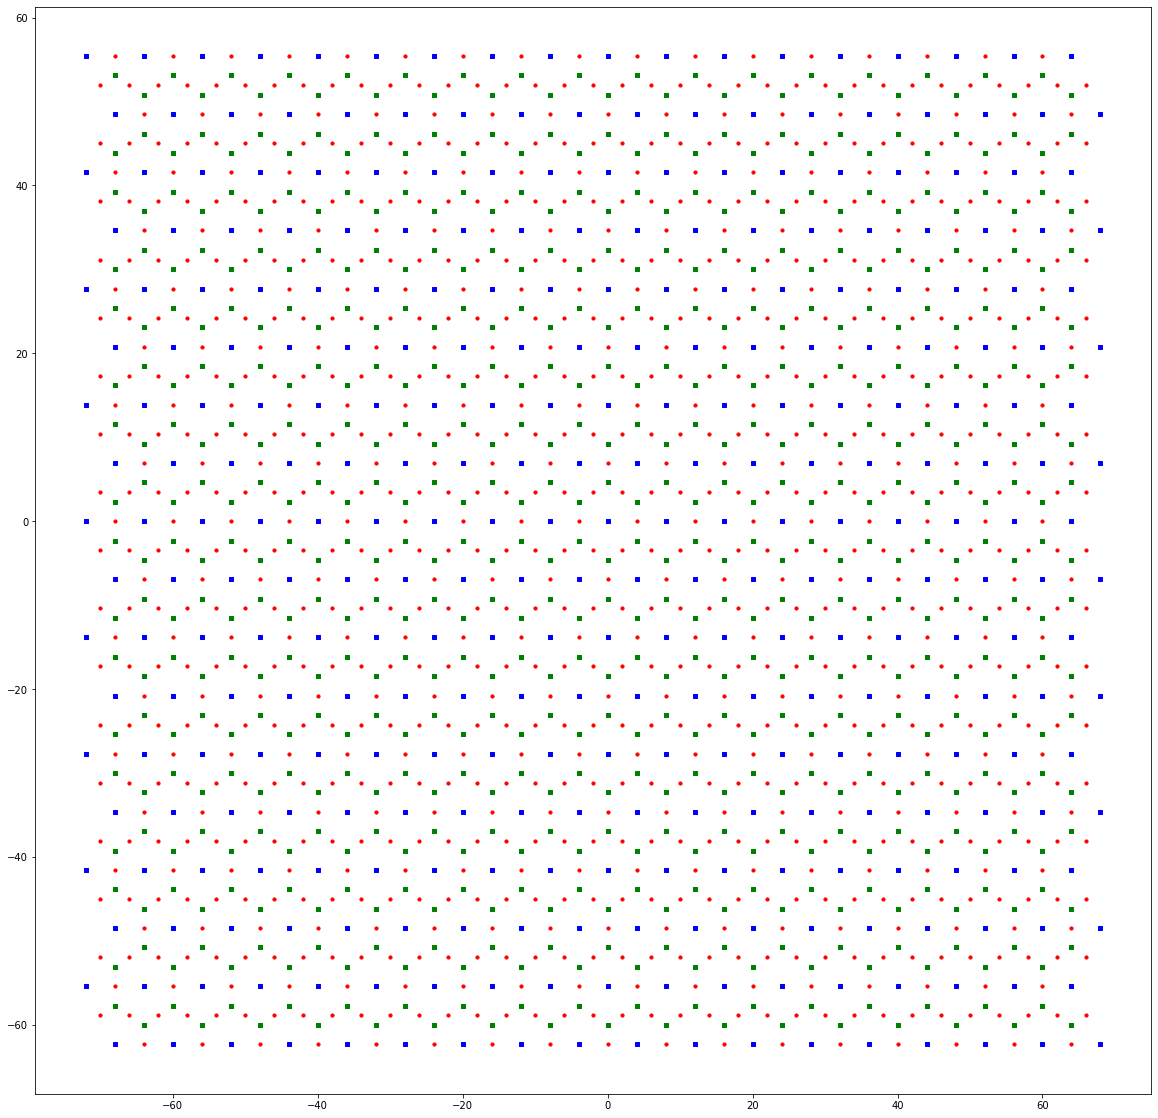

In [9]:
fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(111)

ax1.scatter(points_df.X, points_df.Y, s=10, c='b', marker="s", label='first')
ax1.scatter(lines_df.pw1,lines_df.pw2, s=10, c='r', marker="o", label='second')
ax1.scatter(triangles_df.pw1,triangles_df.pw2, s=10, c='g', marker="s", label='third')